In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
start_date = "2007-01-01"
end_date = "2025-10-07"
nifty = yf.download('^NSEI', start=start_date, end=end_date)
risky_asset_returns = nifty['Close'].resample('M').ffill().pct_change().dropna().squeeze()

[*********************100%***********************]  1 of 1 completed


In [13]:
monthly_safe_rate = (1 + 0.05)**(1/12) - 1
safe_asset_returns = pd.Series(monthly_safe_rate, index=risky_asset_returns.index)

data_in = pd.DataFrame({
    'Risky': risky_asset_returns,
    'Safe': safe_asset_returns
})

In [14]:
def run_cppi(risky_r, safe_r, start_value=1000, floor_pct=0.7, m=3):
    account_value = start_value
    floor = start_value * floor_pct

    dates = risky_r.index
    account_history = pd.Series(index=dates, dtype=float)
    cushion_history = pd.Series(index=dates, dtype=float)
    risky_w_history = pd.Series(index=dates, dtype=float)

    for date in dates:
        cushion = (account_value - floor) / account_value
        risky_w = m * cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1 - risky_w

        risky_w_history.loc[date] = risky_w
        cushion_history.loc[date] = cushion

        risky_alloc = account_value * risky_w
        safe_alloc = account_value * safe_w

        account_value = risky_alloc * (1 + risky_r.loc[date]) + safe_alloc * (1 + safe_r.loc[date])
        account_history.loc[date] = account_value

    backtest_result = pd.DataFrame({
        "Wealth": account_history,
        "Cushion": cushion_history,
        "Risky Allocation": risky_w_history
    })

    return backtest_result

def calculate_drawdown(wealth_series):
    previous_peaks = wealth_series.cummax()
    drawdown = (wealth_series - previous_peaks) / previous_peaks

    return pd.DataFrame({
        "Wealth": wealth_series,
        "Previous Peak": previous_peaks,
        "Drawdown": drawdown
    })

In [15]:
start_value = 1000
floor_pct = 0.70
m = 3

cppi_portfolio_in = run_cppi(data_in['Risky'], data_in['Safe'], start_value=start_value, floor_pct=floor_pct, m=m)
buy_and_hold_portfolio_in = pd.DataFrame({"Wealth": start_value * (1 + data_in['Risky']).cumprod()})

cppi_drawdown_in = calculate_drawdown(cppi_portfolio_in['Wealth'])
buy_and_hold_drawdown_in = calculate_drawdown(buy_and_hold_portfolio_in['Wealth'])

In [16]:
print("--- CPPI Strategy Results (Indian Market) ---")
print(cppi_portfolio_in.tail())
print(f"\nMax CPPI Drawdown: {cppi_drawdown_in['Drawdown'].min()*100:.2f}%")
print("\n--- Buy-and-Hold Strategy Results (NIFTY 50) ---")
print(buy_and_hold_portfolio_in.tail())
print(f"\nMax Buy-and-Hold Drawdown: {buy_and_hold_drawdown_in['Drawdown'].min()*100:.2f}%")

--- CPPI Strategy Results (Indian Market) ---
                 Wealth   Cushion  Risky Allocation
Date                                               
2025-06-30  4029.167056  0.820888               1.0
2025-07-31  3910.946415  0.826267               1.0
2025-08-31  3857.023234  0.821015               1.0
2025-09-30  3886.116487  0.818513               1.0
2025-10-31  3959.785308  0.819872               1.0

Max CPPI Drawdown: -39.90%

--- Buy-and-Hold Strategy Results (NIFTY 50) ---
                 Wealth
Date                   
2025-06-30  5081.711150
2025-07-31  4932.607591
2025-08-31  4864.597993
2025-09-30  4901.291312
2025-10-31  4994.204726

Max Buy-and-Hold Drawdown: -55.12%


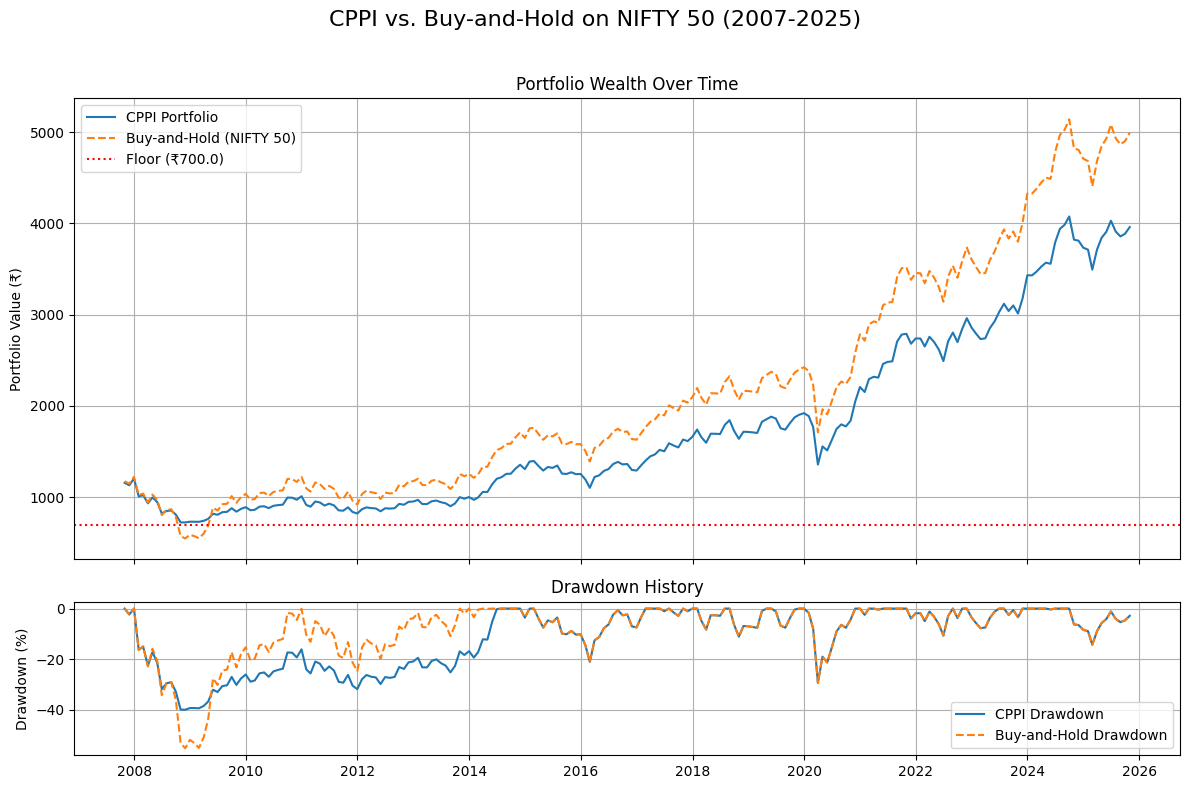

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
plt.suptitle('CPPI vs. Buy-and-Hold on NIFTY 50 (2007-2025)', fontsize=16)

ax1.plot(cppi_portfolio_in['Wealth'], label='CPPI Portfolio')
ax1.plot(buy_and_hold_portfolio_in['Wealth'], label='Buy-and-Hold (NIFTY 50)', linestyle='--')
ax1.axhline(y=start_value * floor_pct, color='r', linestyle=':', label=f'Floor (₹{start_value*floor_pct})')
ax1.set_ylabel('Portfolio Value (₹)')
ax1.set_title('Portfolio Wealth Over Time')
ax1.legend()
ax1.grid(True)

ax2.plot(cppi_drawdown_in['Drawdown']*100, label='CPPI Drawdown')
ax2.plot(buy_and_hold_drawdown_in['Drawdown']*100, label='Buy-and-Hold Drawdown', linestyle='--')
ax2.set_ylabel('Drawdown (%)')
ax2.set_title('Drawdown History')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#ANALYSIS
The results show a classic trade-off between maximizing returns and protecting capital.

Performance: The Buy-and-Hold strategy ended with a higher final wealth (₹4,994.20) compared to the CPPI strategy (₹3,959.78). As seen in the top chart, the orange line (Buy-and-Hold) finished significantly above the blue line (CPPI).

Protection: This lower return from CPPI is the "cost" of the insurance it provides. The primary goal of CPPI is not to outperform but to protect the portfolio from large losses, which it successfully achieved.

##Effective Risk Management

The true value of the CPPI strategy is evident in its risk-mitigating features, clearly visible in the drawdown history.

Drawdown Reduction: The bottom plot shows that during severe market crashes (like in 2008-2009 and 2020), the Buy-and-Hold strategy suffered a massive maximum drawdown of -55.12%. The CPPI strategy, by dynamically shifting funds out of the risky asset, limited its maximum loss to -39.90%. This is a significant reduction in risk.

Floor Guarantee: The top chart confirms that the CPPI portfolio (blue line) never breached its predefined floor of ₹700 (red dotted line). This demonstrates that the core principle of the insurance strategy worked perfectly, guaranteeing a minimum portfolio value.



#CONCLUSION

The CPPI strategy performed exactly as designed: it successfully provided downside protection at the cost of some potential upside.

An investor who followed the Buy-and-Hold strategy would have ended up with more money but would have had to endure a period where their portfolio lost over half its value. An investor using the CPPI strategy would have less wealth at the end but would have been protected from the worst of the market's declines, ensuring their capital stayed above the minimum floor.

Therefore, the CPPI strategy is a success for a risk-averse investor who prioritizes capital preservation over maximizing returns.